# REINFORCE
This notebook shows one the most basic RL algorithms - [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf).  

It was tested on the `CartPole-v1` only.

In [1]:
import sys
from typing import Tuple

import gym
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F


sys.path.append("../")

from push_ups import agent_base
from push_ups.utils import default_network, training_loop

## Define Policy and the Agent
Policy can be some ML model which takes decisions based on the environment state (or the observation if the state is hidden).  
Agent defines how:
1. policy is created (`get_policy` method)
2. action are taken (`take_action` method)
3. policy is updated (`update_policy` method)

In [2]:
class PolicyAgent(agent_base.Agent):
    def __init__(self, env: gym.core.Env, gamma: float = 0.9, lr=0.01, *args, **kwargs):
        """
        :param: gamma: discount factor used to calculate return
        :param: lr: learning rate used in the torch optimizer
        """
        super().__init__(env, gamma, lr, *args, **kwargs)
        self.observations = []
        self.log_action_probabilities = []
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def take_action(self, observation: np.array, *args, **kwargs):
        del args, kwargs  # unused
        if not self.discrete_actions:
            raise NotImplementedError

        observation = torch.from_numpy(observation).float().unsqueeze(0)
        probabilities = self.policy(observation)

        m = Categorical(probabilities)
        action = m.sample()
        log_prob = m.log_prob(action)
        self.log_action_probabilities.append(log_prob)

        return action.item()

    def get_policy(self) -> nn.Module:
        inputs_no = self.get_observations()
        outputs_no = self.get_actions()
        discrete_outputs = self.discrete_actions
        return default_network.Policy(inputs_no, outputs_no, discrete_outputs)

    def update_policy(self, rewards: torch.tensor, *args, **kwargs):
        del args, kwargs  # unused

        eps = np.finfo(np.float32).eps.item()

        returns = self.calculate_returns(rewards)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        for log_prob, R in zip(self.log_action_probabilities, returns):
            policy_loss.append(-log_prob * R)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        del self.log_action_probabilities[:]

    def calculate_returns(self, rewards: torch.tensor) -> torch.tensor:
        returns = torch.flip(rewards, [0])
        for idx, item in enumerate(returns):
            if idx == 0:
                continue
            returns[idx] = item + self.gamma * returns[idx - 1]
        return torch.flip(returns, [0])

## Define the environmnet and the agent

In [3]:
env = gym.make("CartPole-v1")
agent = PolicyAgent(env, gamma=0.9, lr=0.01)

## Run training

In [4]:
running_reward = None
for i_episode in range(4000):
    agent, rewards = training_loop.run_episode(agent, env)
    ep_reward = rewards.sum().item()

    if running_reward is None:
        running_reward = ep_reward
    else:
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    training_loop.print_epiode_stats(i_episode, ep_reward, running_reward, env, rewards)

    if running_reward > env.spec.reward_threshold:
        break

    agent.update_policy(rewards)

Episode 0	Last reward: 17.00	Average reward: 17.00	
Episode 50	Last reward: 32.00	Average reward: 42.90	
Episode 100	Last reward: 102.00	Average reward: 96.83	
Episode 150	Last reward: 246.00	Average reward: 250.67	
Episode 200	Last reward: 134.00	Average reward: 168.69	
Episode 250	Last reward: 140.00	Average reward: 125.81	
Episode 300	Last reward: 141.00	Average reward: 118.80	
Episode 350	Last reward: 197.00	Average reward: 140.37	
Episode 400	Last reward: 85.00	Average reward: 312.28	
Episode 450	Last reward: 196.00	Average reward: 198.34	
Episode 500	Last reward: 400.00	Average reward: 294.28	
Episode 550	Last reward: 71.00	Average reward: 102.47	
Episode 600	Last reward: 112.00	Average reward: 82.68	
Episode 650	Last reward: 224.00	Average reward: 216.12	
Episode 700	Last reward: 102.00	Average reward: 120.36	
Episode 750	Last reward: 325.00	Average reward: 236.46	
Episode 800	Last reward: 261.00	Average reward: 275.50	
Episode 850	Last reward: 500.00	Average reward: 410.81	
Epi

## See the results

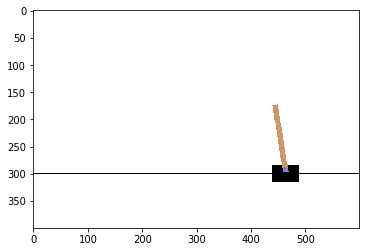

In [5]:
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for i in range(300):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = agent(obs)
    obs, rew, done, info = env.step(action)
    
    if done:
        break